In [1]:
import sys
sys.path.append('../')
from make_representations.cpe_apply import CPE
from utility.file_utility import FileUtility
from multiprocessing import Pool
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from nltk import FreqDist
from proteinseq_util.biophysical import ProtSeqProp
from utility.math_utility import normalize_mat
import scipy.stats as st
from chi2analysis.chi2analysis import Chi2Analysis
from utility.math_utility import get_sym_kl_rows


In [2]:
import re
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt


class HierarchicalClutering(object):
    '''
    classdocs
    '''


    def __init__(self, distance_matrix, labels_out):
        '''
        Constructor
        '''
        z = hac.complete(distance_matrix)
        hac.dendrogram(z,labels=labels_out)
        self.tree = hac.to_tree(z,False)
        self.nwk=self.get_newick(self.tree, "", self.tree.dist, labels_out)
        plt.show()


    def get_newick(self, node, newick, parentdist, leaf_names):
        '''
        :param node:
        :param newick:
        :param parentdist:
        :param leaf_names:
        :return: the Newick format based on the provided distance matrix
        '''
        if node.is_leaf():
            return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
        else:
            if len(newick) > 0:
                newick = "):%.2f%s" % (parentdist - node.dist, newick)
            else:
                newick = ");"
            newick = self.get_newick(node.get_left(), newick, node.dist, leaf_names)
            newick = self.get_newick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
            newick = "(%s" % (newick)
            return newick

In [8]:
class DiMotif(object):
    def __init__(self, pos_fasta, neg_fasta, output_path, segmentation_schemes=10, topN=100):
        '''
        
        '''
        self.pos=FileUtility.read_fasta_sequences(pos_fasta)[0:10]
        self.neg=FileUtility.read_fasta_sequences(neg_fasta)[0:10]
        self.seqs=[seq.lower() for seq in self.pos+self.neg]
        self.labels=[1]*len(self.pos)+[0]*len(self.neg)
        self.segmentation_schemes=segmentation_schemes
        self.load_alpha_distribution()
        self.prepare_segmentations()
        FileUtility.ensure_dir(output_path)
        self.output_path=output_path
        self.motif_extraction(topN)
        
    def load_alpha_distribution(self):
        swiss_size_change=FileUtility.load_obj('../data_config//swiss_1000_samples.pickle')
        all_samples=[]
        for i in tqdm.tqdm(range(0,1000)):
            sample=[]
            for vocab in np.arange(10000,1000000,10000):
                sample.append(swiss_size_change[vocab][i])
            all_samples.append(-np.diff(sample))

        sample_mat=np.mean(normalize_mat(all_samples),axis=0)
        sample_mat_std=np.std(normalize_mat(all_samples),axis=0)
        self.alpha_param = st.alpha.fit(sample_mat)
    
    def get_alpha_samples(self):
        r = st.alpha.rvs(self.alpha_param[0], size=self.segmentation_schemes)
        idx=np.array(np.round(10000+(r*10000)),dtype=np.int32).tolist()
        idx.sort()
        return idx

    def prepare_segmentations(self):
        segmented_seqs=[]
        vocab_sizes=self.get_alpha_samples()
        for i, vocab in tqdm.tqdm(enumerate(vocab_sizes)):
            f=open('../data_config/swissprot_ppe','r')
            CPE_Applier=CPE(f,separator='', merge_size=vocab)
            for idx, seq in tqdm.tqdm(enumerate(self.seqs)):
                if i ==0:
                    segmented_seqs.append([CPE_Applier.segment(seq)])
                else:
                    segmented_seqs[idx]+=[CPE_Applier.segment(seq)]
        self.extended_sequences=[' '.join(l) for l in segmented_seqs]
    
    
    def motif_extraction(self, topn=100):
        cpe_vectorizer = TfidfVectorizer(use_idf=False, analyzer='word',
                                              norm=None, stop_words=[], lowercase=True, binary=False, tokenizer=str.split)
        tf_vec=cpe_vectorizer.fit_transform(self.extended_sequences)
        vocab=cpe_vectorizer.get_feature_names()
        CH=Chi2Analysis(tf_vec,self.labels,vocab)
        vocab_binary=[x[0] for x in CH.extract_features_fdr(self.output_path+'/motifs.txt', N=topn, alpha=5e-2, direction=True, allow_subseq=True, binarization=True, remove_redundant_markers=False) if x[1]>0]
        idxs=[vocab.index(v) for v in vocab_binary]
        pos_matrix=tf_vec.toarray()[0:len(self.pos),idxs]
        DIST=get_sym_kl_rows(pos_matrix.T)
        HC=HierarchicalClutering(DIST,vocab_binary)
        self.motifs=vocab_binary
        self.tree=HC.nwk
        FileUtility.save_list(self.output_path+'/motif_tree.txt', [HC.nwk])

100%|██████████| 1000/1000 [00:00<00:00, 26510.15it/s]
/mounts/Users/student/asgari/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
0it [00:00, ?it/s]
0it [00:00, ?it/s]
3it [00:00, 13.11it/s]
4it [00:00, 10.43it/s]
5it [00:00,  9.28it/s]
6it [00:00,  8.70it/s]
7it [00:00,  8.38it/s]
8it [00:00,  8.13it/s]
9it [00:01,  7.30it/s]
10it [00:01,  7.24it/s]
13it [00:01,  8.57it/s]
15it [00:01,  9.26it/s]
17it [00:01,  9.88it/s]
20it [00:01, 10.87it/s]
1it [00:02,  2.38s/it]
0it [00:00, ?it/s]
3it [00:00, 13.05it/s]
4it [00:00, 10.42it/s]
5it [00:00,  9.29it/s]
6it [00:00,  8.71it/s]
7it [00:00,  8.38it/s]
8it [00:00,  8.14it/s]
9it [00:01,  7.29it/s]
10it [00:01,  7.24it/s]
13it [00:01,  8.56it/s]
15it [00:01,  9.26it/s]
17it [00:01,  9.87it/s]
20it [00:01, 10.86it/s]
2it [00:04,  2.38s/it]
0it [00:00, ?it/s]
3it [00:00, 13.22it/s]
4it [00:00, 10.54it/s]
5it [00:00,  9.38it/s]


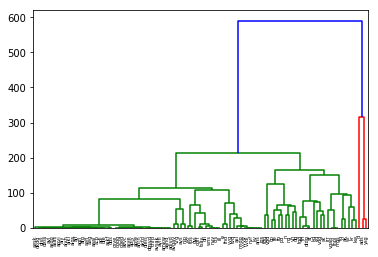

In [9]:
DM=DiMotif('/mounts/data/proj/asgari/dissertation/git_repos/less_important/protein_datasets_new/integrins/positive_integrins.fasta','/mounts/data/proj/asgari/dissertation/git_repos/less_important/protein_datasets_new/integrins/neg_reviewed.fasta','./integrins/')

In [5]:
print(len(DM.extended_sequences))

NameError: name 'DM' is not defined

In [4]:
a,b=MotifProp.get_motifs_pss_biophys(['dve'])

100%|██████████| 1/1 [00:00<00:00, 2480.37it/s]


In [2]:
import sys
sys.path.append('../')
from utility.file_utility import FileUtility
from make_representations.cpe_apply import CPE
from multiprocessing import Pool
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from chi2analysis.chi2analysis import Chi2Analysis
import random

In [ ]:
vocab_sizes=[int(x) for x in FileUtility.load_list('../../protein_datasets/segmentations/alpha_sampled_list.txt')]